In [218]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [219]:
EPS = 5.  # like the one used for the dataset
DELTA = 1e-16
INCREASE_SIZE = 10  # how many times to increase the size of the dataset
NUM_EXPERIMENlTS = 100  # number of experiments to run for each m

# Import Data

In [220]:
import pickle
import numpy as np

np.random.seed(42) # for reproducibility
data_path_age = "data/age_data.pkl"
data_path_working_hours = "data/working_hours_data.pkl"

DATASET = []
## Load Data ##
with open(data_path_age, "rb") as f:
    data = pickle.load(f)
    data = np.concatenate([data] * INCREASE_SIZE)
    DATASET.append({"data":   np.sort(data),
                    "bounds": (0, 100),
                    "g":      1,
                    "name":   "age",
                    "n":      len(data), })
with open(data_path_working_hours, "rb") as f:
    data = pickle.load(f)
    data = np.concatenate([data] * INCREASE_SIZE)
    DATASET.append({"data":   np.sort(data),
                    "bounds": (0, 100),
                    "g":      1,
                    "name":   "working hours",
                    "n":      len(data), })

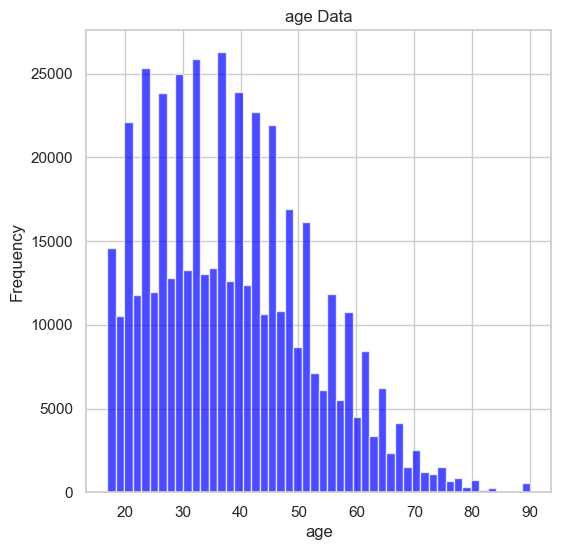

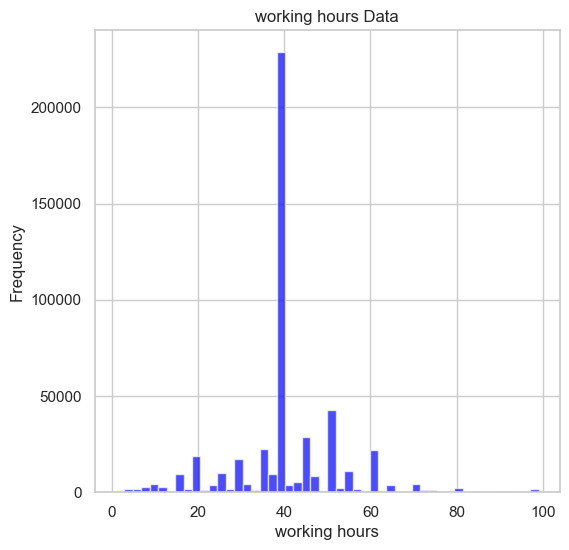

In [221]:
# print histogram
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
for dataset in DATASET:
    data = dataset["data"]
    plt.figure(figsize=(6, 6))
    plt.hist(data, bins=50, color='blue', alpha=0.7)
    plt.title(f"{dataset['name']} Data")
    plt.xlabel(dataset["name"])
    plt.ylabel("Frequency")
    plt.show()

## Post process, add small noise

In [222]:
std = 1e-3
for dataset in DATASET:
    array = dataset["data"]
    n = len(array)
    min_g = 1 / n
    translate = np.cumsum(np.repeat(min_g, n))
    dataset["data"] = np.sort(array + np.random.normal(0, std, size=dataset["data"].shape) + translate)
    dataset["g"] = std / len(dataset["data"])

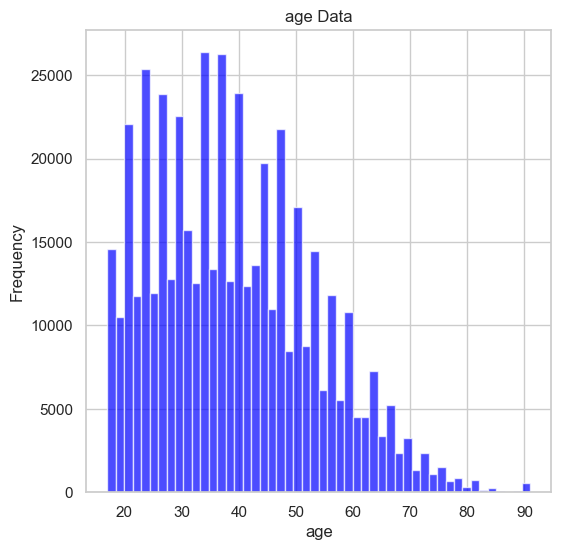

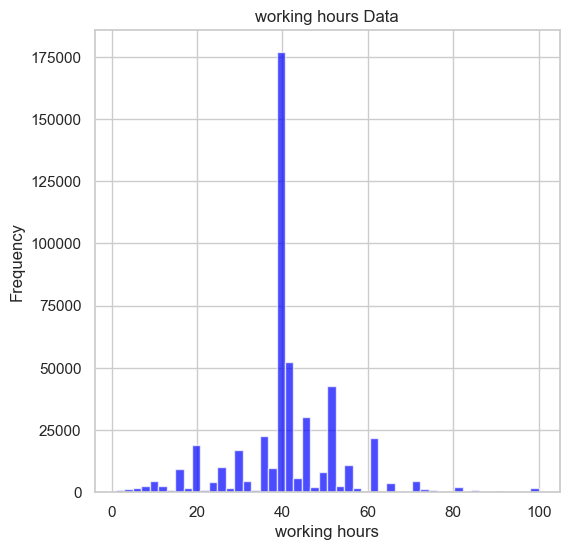

In [223]:
# print histogram
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
for dataset in DATASET:
    data = dataset["data"]
    plt.figure(figsize=(6, 6))
    plt.hist(data, bins=50, color='blue', alpha=0.7)
    plt.title(f"{dataset['name']} Data")
    plt.xlabel(dataset["name"])
    plt.ylabel("Frequency")
    plt.show()

# Set Privacy Budgets

We propose $\varepsilon, \delta$ that are used in SliceQuantiles, and compute the highest $\rho$ for zCDP that implies the same $\varepsilon, \delta$.

In [224]:
from scipy.optimize import root_scalar
import numpy as np


def get_max_rho(eps, delta):
    """
    Get the maximum rho for a given epsilon and delta.
    """
    epsilon_func = lambda rho: rho + np.sqrt(4 * rho * np.log(np.sqrt(np.pi * rho) / delta)) - eps

    # Use a numerical solver to find the root of epsilon_func
    result = root_scalar(epsilon_func, bracket=[1e-10, 10], method='brentq')

    if result.converged:
        return result.root
    else:
        raise ValueError("Failed to find a valid rho for the given epsilon and delta.")


rho = get_max_rho(EPS, DELTA)
print("For eps = {}, delta = {}, max rho = {}".format(EPS, DELTA, rho))

For eps = 5.0, delta = 1e-16, max rho = 0.16042646228545326


# Hyperparameters

In [225]:
RHO = get_max_rho(EPS, DELTA)
M_MAX = 250
M_LIST = range(10, 210, 10)
max_q_list = np.linspace(0, 1, M_MAX + 2)[1:-1]

for dataset in DATASET:
    # add the q_list key
    dataset["q_list"] = max_q_list

In [226]:
records = []  # to store the records of each experiment

In [227]:
import math


def get_statistics(X: np.ndarray, quantiles: np.ndarray, estimates: np.ndarray) -> float:
    """
    Compute the maximum rank error and the mean absolute rank error between the true quantiles and the estimated quantiles.
    :param X: data set
    :param quantiles: a list of quantiles (values in [0, 1])
    :param estimates: a list of estimated qth-quantiles (values in X)
    :return: a dictionary with the maximum rank error and the mean absolute rank error
    """
    # sort the data
    X = np.sort(X)
    n = len(X)

    # for each result, get the position of the closest element in the sorted array
    positions = np.searchsorted(X, estimates)
    true_positions = [math.floor(q * n) for q in quantiles]

    # compute the normalized rank error
    rank_errors = np.abs(positions - true_positions)

    # get statistics
    max_rank_error = np.max(rank_errors)
    mean_rank_error = np.mean(rank_errors)
    output = {
        'max_error':  max_rank_error,
        'mean_error': mean_rank_error  # Kaplan et al. uses this
    }
    return output


# Run SliceQuantiles

## Check correcteness of the privacy parameters

In [228]:
from our_mechanism import SliceQuantile

for swap in (True, False):
    # Check if the privacy parameters are valid for any values of m
    for data_dict in DATASET:
        bound = data_dict["bounds"]
        g = data_dict["g"]
        N = data_dict["n"]
        q_list = data_dict["q_list"]
        mechanism = SliceQuantile(bound=bound, n=N, m=len(q_list), eps=EPS, split=0.5, swap=swap, g=g)
        if not mechanism.is_delta_approximate_DP(delta=DELTA, q_list=q_list):
            raise ValueError(f"For n={N} failed to find a valid delta approximate DP.")
print("All privacy parameters are valid for the given m values.")

All privacy parameters are valid for the given m values.


## Run the experiments

In [229]:
from tqdm import tqdm

for swap in (True, False):
    for data_dict in DATASET:
        bound = data_dict["bounds"]
        data = data_dict["data"]
        g = data_dict["g"]
        N = data_dict["n"]
        q_list = data_dict["q_list"]
        for m in tqdm(M_LIST):
            mechanism = SliceQuantile(bound=bound, n=N, m=m, eps=EPS, split=0.5, swap=swap, g=g)
            for _ in range(NUM_EXPERIMENTS):
                Q_LIST = np.sort(np.random.choice(q_list, size=m, replace=False))
                estimates = mechanism.approximate_mechanism(data, q_list=Q_LIST, delta=DELTA, verbose=True)
                statistics = get_statistics(data, quantiles=Q_LIST, estimates=estimates)
                records.append({
                    "m":          m,
                    "max_error":  statistics["max_error"],
                    "mean_error": statistics["mean_error"],
                    "Algorithm":  "SliceQuantiles",
                    "dataset":    data_dict["name"],
                    "swap":       swap,
                })

100%|██████████| 20/20 [01:15<00:00,  3.78s/it]


# Run Approximate Quantiles, from Kaplan et al.

In [230]:
from DP_AQ import approximate_quantiles_algo

for swap in (True, False):
    for data_dict in DATASET:
        bound = data_dict["bounds"]
        data = data_dict["data"]
        g = data_dict["g"]
        N = data_dict["n"]
        q_list = data_dict["q_list"]
        for m in tqdm(M_LIST):
            # Q_LIST = q_list[:m]
            for _ in range(NUM_EXPERIMENTS):
                Q_LIST = np.sort(np.random.choice(q_list, size=m, replace=False))
                estimates = approximate_quantiles_algo(array=data, quantiles=Q_LIST, bounds=bound,
                                                       epsilon=RHO, swap=swap, cdp=True, random_gauss=False)
                statistics = get_statistics(data, quantiles=Q_LIST, estimates=estimates)
                records.append({
                    "m":          m,
                    "max_error":  statistics["max_error"],
                    "mean_error": statistics["mean_error"],
                    "Algorithm":  "Approximate Quantiles",
                    "dataset":    data_dict["name"],
                    "swap":       swap,
                })

  0%|          | 0/20 [00:00<?, ?it/s]/Users/fabrizioboninsegna/Documents/GitHub/GitHub/DP_CC_quantiles/DP_AQ/single_quantile_algo.py:31: RuntimeWarning: divide by zero encountered in log
  idx_left = racing_sample(np.log(intervals) + (epsilon / (2.0 * sensitivity) * utility))
100%|██████████| 20/20 [03:59<00:00, 11.98s/it]


# Run Approximate Quantiles, from Kaplan et al. PURE

In [231]:
from DP_AQ import approximate_quantiles_algo

for swap in (True, False):
    for data_dict in DATASET:
        bound = data_dict["bounds"]
        data = data_dict["data"]
        g = data_dict["g"]
        N = data_dict["n"]
        q_list = data_dict["q_list"]
        for m in tqdm(M_LIST):
            # Q_LIST = q_list[:m]
            for _ in range(NUM_EXPERIMENTS):
                Q_LIST = np.sort(np.random.choice(q_list, size=m, replace=False))
                estimates = approximate_quantiles_algo(array=data, quantiles=Q_LIST, bounds=bound,
                                                       epsilon=EPS, swap=swap, cdp=False, random_gauss=False)
                statistics = get_statistics(data, quantiles=Q_LIST, estimates=estimates)
                records.append({
                    "m":          m,
                    "max_error":  statistics["max_error"],
                    "mean_error": statistics["mean_error"],
                    "Algorithm":  "Approximate Quantiles Pure",
                    "dataset":    data_dict["name"],
                    "swap":       swap,
                })

  0%|          | 0/20 [00:00<?, ?it/s]/Users/fabrizioboninsegna/Documents/GitHub/GitHub/DP_CC_quantiles/DP_AQ/single_quantile_algo.py:31: RuntimeWarning: divide by zero encountered in log
  idx_left = racing_sample(np.log(intervals) + (epsilon / (2.0 * sensitivity) * utility))
100%|██████████| 20/20 [03:58<00:00, 11.90s/it]


In [232]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

sns.set_theme(style="white")

DF = pd.DataFrame(records)

data_to_save = {
    "data": DF,
    "epsilon": EPS,
    "delta": DELTA,
    "increase_size": INCREASE_SIZE,
    "number_of_experiments": NUM_EXPERIMENTS,
}

# save pickle file
with open("data_3.pkl", "wb") as f:
    pickle.dump(data_to_save, f)

# Plot the results

In [237]:
# import pickle data
with open("data_1.pkl", "rb") as f:
    data = pickle.load(f)
# upload DF
DF = data["data"]

## Max Error

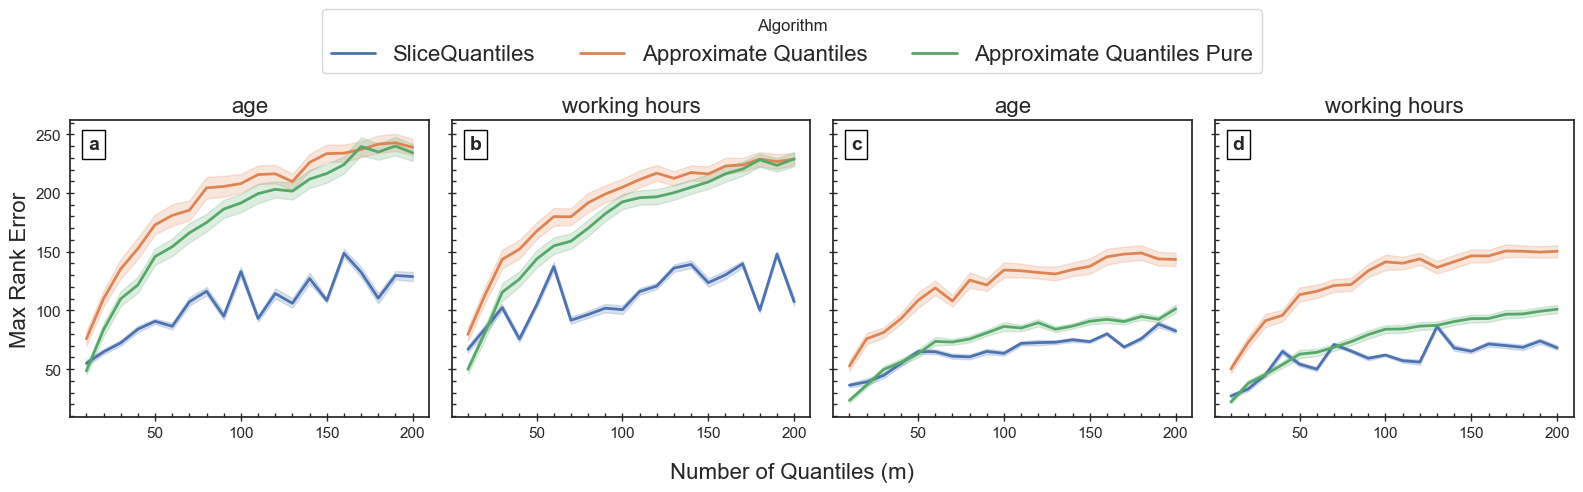

In [238]:
from matplotlib.ticker import AutoMinorLocator

# Dynamically calculate rows and columns based on the number of plots
num_plots = len(DATASET) * 2  # 2 for swap=True and swap=False
cols = 4  # Fixed number of columns
rows = (num_plots + cols - 1) // cols  # Calculate rows dynamically

# Create a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), sharex=True, sharey=True)
axes = axes.flatten()

x_lables = ["a", "b", "c", "d"]

count = 0
for swap in (True, False):
    for data_dict in DATASET:
        if count >= len(axes):  # Prevent exceeding subplot count
            break
        ax = axes[count]
        key = data_dict["name"]
        df = DF[(DF["dataset"] == key) & (DF["swap"] == swap)]
        sns.lineplot(
            data=df,
            x="m",
            y="max_error",
            hue="Algorithm",
            errorbar=('ci', 95),  # confidence interval 95%
            linewidth=2,
            ax=ax,
        )
        ax.set_title(key, fontsize=16)
        ax.set_xlabel("", fontsize=16)
        ax.set_ylabel("Max Rank Error", fontsize=16)
        ax.legend().remove()  # Remove individual legends

        # Customize ticks: keep numbers and add small lines
        # Major ticks (with labels)
        ax.tick_params(axis='x', which='major', direction='inout', length=6, width=1, bottom=True)
        ax.tick_params(axis='y', which='major', direction='inout', length=6, width=1, left=True)

        # Minor ticks (no labels, just small marks)
        ax.xaxis.set_minor_locator(AutoMinorLocator())  # auto minor ticks for x
        ax.yaxis.set_minor_locator(AutoMinorLocator())  # auto minor ticks for y
        ax.tick_params(axis='x', which='minor', direction='in', length=3, width=1, bottom=True)
        ax.tick_params(axis='y', which='minor', direction='in', length=3, width=1, left=True)

        # Add a small box with the label
        ax.text(0.05, 0.95, x_lables[count], transform=ax.transAxes,
                fontsize=14, fontweight='bold', va='top', ha='left',
                bbox=dict(facecolor='white', edgecolor='black'))

        count += 1

# Remove unused subplots
if count < len(axes):
    for j in range(count, len(axes)):
        fig.delaxes(axes[j])

# Add a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), title="Algorithm",
           bbox_to_anchor=(0.5, 1.15), fontsize=16)

# Add a single shared x-label
fig.text(0.5, -0.05, "Number of Quantiles (m)", ha='center', fontsize=16)

# Adjust layout to fit the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()